# Introduction

Acute Lymphoblastic Leukemia(ALL) is the most harmful cancer seen in both adults and infants. When we talk about the United States, it is quite frequent among children within the age category of 2 - 5 years. Furthermore, we must be aware of the major symptoms that precede ALL. They include enlarged lymph nodes, bleeding gums, dizziness, and repeated infections over a short time.
Another reason for selecting ALL was some intriguing quantitative data. As per the analysis performed in 2015, about 876,000 people worldwide were affected by this cancer, resulting in about 111,000 deaths. Therefore, Looking at the huge numbers and seriousness of this disease, we decided to create our image classification training model on this topic.


![image.jpg](nm-pediatric-leukemia-super-drug_feature.jpg)


### Content

1. [Load and Check Data](#1)
1. [Crop Black Edges In Image](#2)
1. [Feature Extraction with ResNet50](#3)
1. [Data Scaling](#4)
1. [Feature Selection Methods](#5)
    * [ANOVA](#6)
    * [Recursive Feature Elimination (RFE)](#7)
1. [Train / Test Split](#8)
1. [Classification with ML Algorithms](#9)
    * [kNN](#10)
    * [SVM](#11)



In [1]:
!pip install opencv-python

In [2]:
import numpy as np 
import pandas as pd 
import os
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
import glob

<a id='1'></a><br>
# Load and Check Data

In [3]:
root_PATH = 'E://python codes'
train_dataset_0_all = glob.glob(root_PATH + '/project/C-NMC_Leukemia/training_data/fold_0/all/*.bmp')
train_dataset_0_hem = glob.glob(root_PATH + '/project/C-NMC_Leukemia/training_data/fold_0/hem/*.bmp')
train_dataset_1_all = glob.glob(root_PATH + '/project/C-NMC_Leukemia/training_data/fold_1/all/*.bmp')
train_dataset_1_hem = glob.glob(root_PATH + '/project/C-NMC_Leukemia/training_data/fold_1/hem/*.bmp')
train_dataset_2_all = glob.glob(root_PATH + '/project/C-NMC_Leukemia/training_data/fold_2/all/*.bmp')
train_dataset_2_hem = glob.glob(root_PATH + '/project/C-NMC_Leukemia/training_data/fold_2/hem/*.bmp')

In [4]:
# Merging data:-
A=[]
H=[]

A.extend(train_dataset_0_all)
A.extend(train_dataset_1_all)
A.extend(train_dataset_2_all)

H.extend(train_dataset_0_hem)
H.extend(train_dataset_1_hem)
H.extend(train_dataset_2_hem)
f=A+H
print(len(A))
print(len(H))

# make labels :-
LabelA = float('NaN')*len(f)


# Convert to pandas dataframe for easy access:-

df = pd.DataFrame({'path':f, 'label':LabelA})
df = df.sample(frac=1).reset_index(drop=True)

FILENAMES = df['path']
LABELS = df['label']

print('Final Merged Data:-')
df

7272
3389
Final Merged Data:-


,path,label
0,E://python codes/project/C-NMC_Leukemia/traini...,NaN
1,E://python codes/project/C-NMC_Leukemia/traini...,NaN
2,E://python codes/project/C-NMC_Leukemia/traini...,NaN
3,E://python codes/project/C-NMC_Leukemia/traini...,NaN
4,E://python codes/project/C-NMC_Leukemia/traini...,NaN
...,...,...
10656,E://python codes/project/C-NMC_Leukemia/traini...,NaN
10657,E://python codes/project/C-NMC_Leukemia/traini...,NaN
10658,E://python codes/project/C-NMC_Leukemia/traini...,NaN
10659,E://python codes/project/C-NMC_Leukemia/traini...,NaN


In [5]:
df["label"][0:7272] = 1 # ALL
df["label"][7272:10661] = 0 # HEM

C:\Users\kesha\AppData\Local\Temp\ipykernel_23012\335980286.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["label"][0:7272] = 1 # ALL
C:\Users\kesha\AppData\Local\Temp\ipykernel_23012\335980286.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["label"][7272:10661] = 0 # HEM


In [6]:
df["label"] = df["label"].astype("int64")

<a id='2'></a><br>
# Crop Black Edges In Image

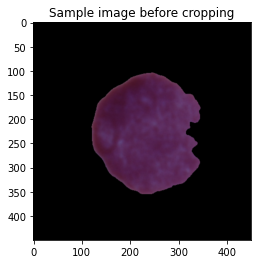

In [12]:
image = cv.imread(df["path"][958])
plt.imshow(image)
plt.title("Sample image before cropping")
plt.show()

In [13]:
imagelist = []
for i in range(len(f)):
    im = cv.imread(df["path"][i])
    gy = cv.cvtColor(im, cv.COLOR_BGR2GRAY)  #convert from rgb to gray
    thresh = cv.threshold(gy, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]  #separate foreground from background

    result = cv.bitwise_and(im, im, mask=thresh) #returns an array that corresponds to the resulting image from the merger of the given two images
    result[thresh==0] = [255,255,255] 
    (x, y, z_) = np.where(result > 0)
    mnx = (np.min(x))
    mxx = (np.max(x))
    mny = (np.min(y))
    mxy = (np.max(y))
    crop_img = image[mnx:mxx,mny:mxy,:]
    crop_img_r = cv.resize(crop_img, (224,224))
    imagelist.append(crop_img_r)

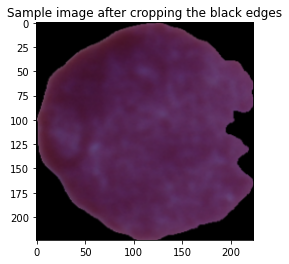

In [14]:
plt.imshow(imagelist[958])
plt.title("Sample image after cropping the black edges")
plt.show()

<a id='3'></a><br>
# Feature Extraction with ResNet50

In [15]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input

In [16]:
model = ResNet50(weights='imagenet',include_top=False,pooling="avg")
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

In [17]:
features_list = []
for i in range(len(imagelist)):
            
    image = imagelist[i].reshape(-1, 224, 224, 3)
    image = preprocess_input(image)

    #Reshaping
    features = model.predict(image).reshape(2048,)
    
    features_list.append(features)

1/1 [==============================] - 3s 3s/step


In [18]:
features_df = pd.DataFrame(features_list)  #convert to dataframe

In [19]:
features_df["labels"] = df["label"]     

In [20]:
x = features_df.drop(['labels'], axis = 1)
y = features_df.loc[:,"labels"].values

In [21]:
x

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,6.305602,0.159321,0.091827,0.109119,0.426656,0.000000,0.027562,0.103975,0.313630,0.067067,...,0.030901,0.000000,0.271043,0.588972,0.171431,0.011786,0.278184,0.324287,0.327238,0.229077
1,3.975705,0.252218,0.000000,0.181694,0.058711,0.036391,0.167243,0.004560,0.054030,0.055479,...,0.195659,0.002198,0.281769,0.446152,1.060017,0.034379,0.378118,0.244862,0.250367,0.784263
2,3.034526,0.000000,0.005278,0.088596,0.886075,0.000000,0.391254,0.009268,0.141597,0.426420,...,0.754663,0.000000,0.082290,0.000000,0.426177,0.031224,0.194848,0.062187,0.410292,0.218977
3,6.732617,0.028272,0.157560,0.094488,0.014191,0.000000,0.070834,0.104612,0.022409,0.029040,...,0.150627,0.000000,0.346182,0.690546,0.039591,0.018836,0.086924,0.629437,0.184610,0.598387
4,3.363248,0.055355,0.000000,0.001277,0.788228,0.000000,0.477205,0.022581,0.000000,0.072359,...,0.108615,0.000000,0.000000,0.000000,0.282842,0.011569,0.037014,0.154148,0.353099,0.741040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10656,2.693955,0.020883,0.021898,0.493938,0.669063,0.000000,0.242759,0.003077,0.126153,0.258793,...,0.681591,0.000000,0.094014,0.027149,0.290738,0.008708,0.160970,0.059710,0.763888,0.427263
10657,3.785161,0.000000,0.009546,0.290790,0.981209,0.000000,0.276963,0.000000,0.032514,0.196602,...,0.671532,0.000000,0.000000,0.007004,0.021283,0.045905,0.150592,0.052265,0.758809,0.795410
10658,4.809916,0.193060,0.000000,0.103754,0.361522,0.000000,0.276515,0.000000,0.325379,0.078323,...,0.262593,0.000000,0.102073,0.466069,0.813219,0.012965,0.250242,0.314552,0.190062,0.455658
10659,7.566206,0.048417,0.182618,0.067110,0.008422,0.000000,0.034549,0.058025,0.037996,0.036431,...,0.175109,0.000000,0.119952,0.575906,0.053710,0.000000,0.116517,0.534635,0.206420,0.610255


In [22]:
print("Features before Selection:{} ".format(x.shape[1]))

Features before Selection:2048 


In [23]:
y

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

<a id='4'></a><br>
# Data Scaling

In [24]:
from sklearn.preprocessing import MinMaxScaler
# Create the scaler
scaler = MinMaxScaler()

# Fit the scaler to the data
scaler.fit(x)

# Transform the data
scaled_data = scaler.transform(x)

In [25]:
scaled_data = pd.DataFrame(scaled_data)

<a id='5'></a><br>
# Feature Selection Methods

<a id='6'></a><br>
## ANOVA 

In [26]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

def anova_fs():
    
    selector = SelectKBest(score_func=f_classif, k=500) # k is number of features
    selector.fit(scaled_data, y)

    cols = selector.get_support(indices=True)
    anova_x = scaled_data[cols]
    return anova_x

<a id='7'></a><br>
## Recursive Feature Elimination (RFE)

In [27]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

def RFE_fs():
    rfe_selector = RFE(estimator=RandomForestClassifier())
    rfe_selector.fit(scaled_data, y)
    
    rfe_support = rfe_selector.get_support()
    rfe_feature = scaled_data.loc[:,rfe_support].columns.tolist()
    
    rfe_x = scaled_data[rfe_feature]
    return rfe_x

In [31]:
fs_x = RFE_fs() # feature selection methods "anova_fs", "RFE_fs"

In [32]:
print(f"Number of features after feature selection: {fs_x.shape[1]}")

Number of features after feature selection: 1024


<a id='9'></a><br>
# Train Test Split

In [33]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(fs_x, y, test_size = 0.2, random_state = 42)

<a id='10'></a><br>
# Classification with ML Algorithms

In [34]:
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
from sklearn.model_selection import GridSearchCV

<a id='11'></a><br>
## kNN

In [36]:
neig = np.arange(1, 20)
accuracytrain = []
accuracytest = []

for i, k in enumerate(neig):

    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train,y_train)
    prediction_ = knn.predict(x_test)
    accuracytrain.append(knn.score(x_train, y_train))
    accuracytest.append(knn.score(x_test, y_test))
    
print("Best accuracy is {} with K = {}".format(np.max(accuracytest),1+accuracytest.index(np.max(accuracytest))))

Best accuracy is 0.6680731364275668 with K = 19


In [39]:
knn = KNeighborsClassifier(n_neighbors=19)
knn.fit(x_train,y_train)
predicted = knn.predict(x_test)
score = knn.score(x_test, y_test)
knn_score_ = np.mean(score)

print('Accuracy : %.3f' % (knn_score_))

Accuracy : 0.668


In [41]:
p=precision_score(y_test, predicted) 
print('Precision : %.3f' % (p))

r=recall_score(y_test, predicted) 
print('Recall : %.3f' % (r))

f1=f1_score(y_test, predicted) 
print('F1-score: %.3f' % (f1))



Precision : 0.685
Recall : 0.952
F1-score: 0.796


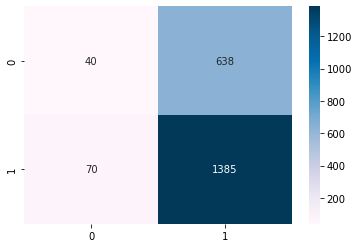

In [42]:
cf_matrix = confusion_matrix(y_test, predicted)
sns.heatmap(cf_matrix, cmap="PuBu", annot=True, fmt='.0f')
plt.show()

<a id='12'></a><br>
## SVM

In [43]:
param_grid_svm = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'poly']}
 
SVM_grid = GridSearchCV(svm.SVC(), param_grid_svm, cv=5)
SVM_grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'poly']})

In [44]:
print(SVM_grid.best_params_)
 
print(SVM_grid.best_estimator_)

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=0.1, gamma=1)


In [45]:
svmmodel = svm.SVC(C=0.1, gamma=1, kernel='rbf')
svmmodel.fit(x_train,y_train)
predicted = svmmodel.predict(x_test)
scoresvm = svmmodel.score(x_test, y_test)
scoresvmmean = np.mean(score)

print('Accuracy : %.2f' % (scoresvmmean))

Accuracy : 0.67


In [46]:
p=precision_score(y_test, predicted) 
print('precision : %.3f' % (p))

r=recall_score(y_test, predicted) 
print('recall : %.3f' % (r))

f1=f1_score(y_test, predicted) 
print('f1-score: %.3f' % (f1))


precision : 0.682
recall : 1.000
f1-score: 0.811


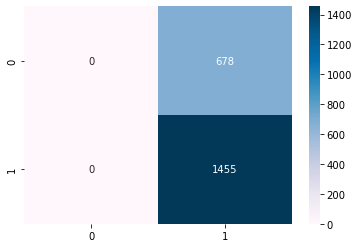

In [47]:
cf_matrix = confusion_matrix(y_test, predicted)
sns.heatmap(cf_matrix, cmap="PuBu", annot=True, fmt='.0f')
plt.show()